# Mentorship: Activation

This notebook digs into the effect access to a mentor has on activation. We know that some newcomers with access to a mentor will ask them a question within the first 24 hours, thus triggering our activation metrics. We'll therefore need to measure this both with and without mentor questions to understand whether it supplements or replaces activation.

In [1]:
library(tidyverse)
library(broom)

# library(brms) # install.packages("brms")
# library(loo) # install.packages("loo")
# library(rstanarm) # install.packages("rstanarm")

library(lubridate)

library(lme4)

library(here)

Warning message:
“package ‘tidyverse’ was built under R version 4.2.3”
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Warning message:
“package ‘readr’ was built under R version 4.2.3”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.3”
Warning message:
“package ‘lubridate’ was built under R version 4.2.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ──────────────────────────────────────

# R Configuration variables

In [2]:
## NOTE: `loo`, which we use for model comparisons, has a tendency to use lots or run out of memory.
## Therefore, I've often had to set mc.cores to 1 before running it. However, if we set its `pointwise`
## parameter, it'll use less memory. And it'll use BLAS, so we restrict the number of BLAS threads to 1.
## Then mc.cores controls the number of parallel processes.

## blas_set_num_threads() also controls the number of threads that glmer() uses. Depending on the load
## on the server at the time we're doing our analysis we can tune the number of threads.

library(RhpcBLASctl)
blas_set_num_threads(1)
options(mc.cores = 4, digits = 3, scipen = 500)

# Give me wider plots, please
options(repr.plot.width = 14, repr.plot.height = 7)

Warning message:
“package ‘RhpcBLASctl’ was built under R version 4.2.3”


# Configuration variables

In [3]:
## Path to the dataset with user information
user_dataset_filename <- here('datasets', 'mentorship_users.tsv')

## Column types in the user info dataset:
## wiki, experiment group, and platform are all factors,
## registration timestamp is treated as character (parsed by lubridate later),
## the other columns are integers or doubles
user_dataset_column_types <- 'ficffiiflldd'

## Path to the dataset with Welcome Survey responses
survey_dataset_filename <- here('datasets', 'mentorship_survey_responses.tsv')

## Column types in the survey response dataset
survey_dataset_column_types <- 'fifffd'

## Path to the dataset with mentorship question edit data
mentor_edit_dataset_filename <- here('datasets', 'mentorship_edits.tsv')

## Column types in the mentorship question edit data
## We're skipping columns 8 & 9 because wiki_db and user_id are duplicated
mentor_edit_dataset_column_types <- 'ficffdd__iici'

## Wide dataset with editing data, used specifically for this type of analysis
editing_dataset_filename <- here('datasets', 'mentorship_editing_data.tsv')

## Column types in the editing dataset
## wiki, experiment group, and platform are all factors,
## registration timestamp is treated as character (parsed by lubridate later),
## the other columns are integers
editing_dataset_column_types <- 'ficffddiiiiiiiiiiiiiiii'

# Data import and setup

In [4]:
## Function that takes in the filename of the user edit data, reads it in,
## and creates all the various derived columns we need.
read_user_dataset <- function(dataset_filename, dataset_column_types) {
    read_tsv(
        dataset_filename,
        col_types = dataset_column_types) %>%
    mutate(
        # Parse the timestamp
        user_registration_ts = ymd_hms(user_registration),
        # Convert multiple variables to factors or boolean
        wiki_name = ifelse(wiki_db == 'eswiki', 'Spanish', 'English'),
        platform_name = ifelse(platform == 'desktop', 'Desktop', 'Mobile web'),
        has_mentor = ifelse(mentor_enabled == 1, TRUE, FALSE),
        # Number of edits:
        num_total_edits_24hrs = num_article_edits_24hrs + num_other_edits_24hrs,
        num_total_edits_2w = num_article_edits_2w + num_other_edits_2w,
        num_total_edits = num_total_edits_24hrs + num_total_edits_2w,
        num_total_article_edits = num_article_edits_24hrs + num_article_edits_2w,
        num_total_other_edits = num_other_edits_24hrs + num_total_edits_2w,
        num_total_edits_24hrs_no_mentor = num_total_edits_24hrs - num_mentorship_edits_24hrs,
        num_total_edits_2w_no_mentor = num_total_edits_2w - num_mentorship_edits_2w,
        num_total_edits_no_mentor = num_total_edits_24hrs_no_mentor + num_total_edits_2w_no_mentor,
        # Log number of total edits is used as a control variable in the revert analysis
        log_num_total_edits = log(1 + num_total_edits),
        # Number of reverts:
        num_reverts_24hrs = num_article_reverts_24hrs + num_other_reverts_24hrs,
        num_reverts_2w = num_article_reverts_2w + num_other_reverts_2w,
        num_total_reverts = num_reverts_24hrs + num_reverts_2w,
        ## Control variables for the number of edits made (used for ex. in revert analysis)
        log_num_article_edits_24hrs = log(1 + num_article_edits_24hrs),
        log_num_other_edits_24hrs = log(1 + num_other_edits_24hrs),
        log_num_edits_24hrs = log(1 + num_article_edits_24hrs + num_other_edits_24hrs),
        # Control variables for the number of constructive edits made
        log_num_const_article_edits_24hrs = log(
            1 + num_article_edits_24hrs - num_article_reverts_24hrs),
        log_num_const_other_edits_24hrs = log(
            1 + num_other_edits_24hrs - num_other_reverts_24hrs),
        log_num_const_edits_24hrs = log(
            1 + num_article_edits_24hrs + num_other_edits_24hrs -
                num_article_reverts_24hrs - num_other_reverts_24hrs),
        # Revert rate:
        prop_rev_edits = ifelse(num_total_edits > 0, num_total_reverts / num_total_edits, 0),
        # Did they activate?
        is_activated_article = num_article_edits_24hrs > 0,
        is_activated_other = num_other_edits_24hrs > 0,
        is_activated = is_activated_article | is_activated_other,
        # Did they activate through constructive edits?
        is_const_activated_article = (num_article_edits_24hrs - num_article_reverts_24hrs) > 0,
        is_const_activated_other = (num_other_edits_24hrs - num_other_reverts_24hrs) > 0,
        is_const_activated = is_const_activated_article | is_const_activated_other,
        # Did they activate through mentorship?
        is_activated_mentor = num_mentorship_edits_24hrs > 0,
        # Did they activate for other reasons than asking their mentor?
        is_activated_no_mentor = num_total_edits_24hrs_no_mentor > 0,
        # Were they retained?
        is_retained_article = is_activated_article & (num_article_edits_2w > 0),
        is_retained_other = is_activated_other & (num_other_edits_2w > 0),
        is_retained = is_activated & ((num_article_edits_2w + num_other_edits_2w) > 0),
        # Were they retained through constructive edits?
        is_const_retained_article = is_const_activated_article &
            ((num_article_edits_2w - num_article_reverts_2w) > 0),
        is_const_retained_other = is_const_activated_other &
            ((num_other_edits_2w - num_other_reverts_2w) > 0),
        is_const_retained = is_const_activated &
            ((num_article_edits_2w + num_other_edits_2w -
              num_article_reverts_2w - num_other_reverts_2w) > 0)
    ) 
}

In [5]:
editing_data <- read_user_dataset(editing_dataset_filename, editing_dataset_column_types)

In [6]:
nrow(editing_data)

[1] 133829

In [7]:
survey_data <- read_tsv(survey_dataset_filename, col_types = survey_dataset_column_types)

In [8]:
editing_with_surveys <- editing_data |>
    inner_join(survey_data, by = c('wiki_db', 'user_id'))

## Checking number of accounts for each wiki

We might be looking at very small wikis, in case we might want to not include them in the analysis.

In [ ]:
editing_data %>%
    group_by(wiki_db, platform, mentor_enabled) %>%
    summarize(n = n())

We filter out users with `mentor_enabled` set to 2 because they're so few of them. I suspect they disabled mentorship themselves.

In [10]:
editing_data <- editing_data |>
    filter(mentor_enabled < 2)

In [ ]:
editing_data |>
    group_by(wiki_db, platform, mentor_enabled) |>
    summarize(n = n()) |>
    mutate(per_group = sum(n)) |>
    mutate(perc = 100 * n / per_group)

In [10]:
editing_data |>
    group_by(wiki_db, mentor_enabled) |>
    tally() |>
    mutate(per_group = sum(n)) |>
    mutate(perc = 100 * n / per_group)

wiki_db mentor_enabled n      per_group perc
1 enwiki  0              101742 114512    88.8
2 enwiki  1               12770 114512    11.2
3 eswiki  0                9646  19305    50.0
4 eswiki  1                9659  19305    50.0

# Activation Proportions

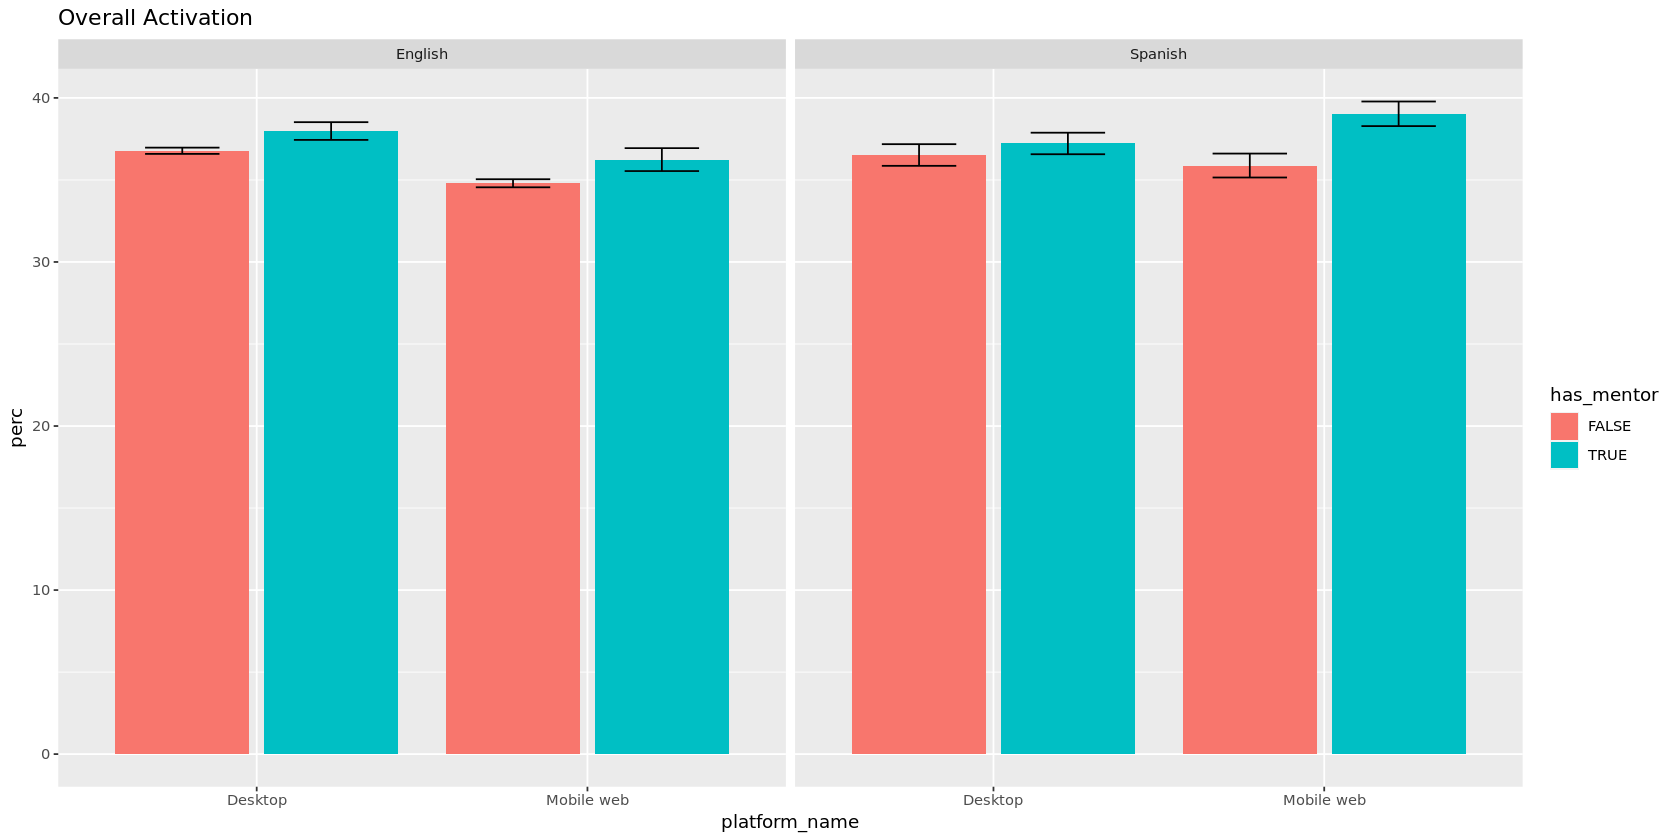

In [26]:
editing_data %>%
    group_by(wiki_name, platform_name, has_mentor, is_activated) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_activated == TRUE) %>%
    ggplot(aes(x = platform_name, y = perc, fill = has_mentor)) +
        labs(title = 'Overall Activation') +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5)) +
        facet_grid(. ~ wiki_name)

In [27]:
editing_data %>%
    group_by(wiki_name, platform_name, has_mentor, is_activated_no_mentor) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_activated_no_mentor == TRUE) %>%
    ggplot(aes(x = platform_name, y = perc, fill = has_mentor)) +
        labs(title = 'Activation without mentor questions') +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5)) +
        facet_grid(. ~ wiki_name)

It looks like mentorship might *replace* editing activity on desktop. It looks like it to some extent does it on mobile too, e.g. on English, but on Spanish there's still an increase.

In [42]:
options(repr.plot.width = 16, repr.plot.height = 9)
editing_data %>%
    group_by(wiki_name, platform_name, has_mentor, is_const_activated_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_const_activated_article == TRUE) %>%
    ggplot(aes(x = platform_name, y = perc, fill = has_mentor)) +
        labs(title = 'Constructive article activation') +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5)) +
        facet_grid(. ~ wiki_name)

### Improved graphs

We'll try showing two graphs for each wiki, one with all edits and one with the mentor questions removed. That can show the activation rate increase coming through mentor questions, and how that disappears.

In [109]:
editing_data |>
    group_by(wiki_name, platform_name, has_mentor, is_activated) |>
    summarize(n_users = n(), .groups = 'drop_last') |>
    mutate(per_group = sum(n_users))

wiki_name platform_name has_mentor is_activated n_users per_group
1  English   Desktop       FALSE      FALSE        40431   63952    
2  English   Desktop       FALSE       TRUE        23521   63952    
3  English   Desktop        TRUE      FALSE         4990    8046    
4  English   Desktop        TRUE       TRUE         3056    8046    
5  English   Mobile web    FALSE      FALSE        24640   37790    
6  English   Mobile web    FALSE       TRUE        13150   37790    
7  English   Mobile web     TRUE      FALSE         3012    4724    
8  English   Mobile web     TRUE       TRUE         1712    4724    
9  Spanish   Desktop       FALSE      FALSE         3372    5312    
10 Spanish   Desktop       FALSE       TRUE         1940    5312    
11 Spanish   Desktop        TRUE      FALSE         3405    5424    
12 Spanish   Desktop        TRUE       TRUE         2019    5424    
13 Spanish   Mobile web    FALSE      FALSE         2779    4334    
14 Spanish   Mobile web    FALSE       TRUE         1555    4334    
15 Spanish   Mobile web     TRUE      FALSE         2582    4235    
16 Spanish   Mobile web     TRUE       TRUE         1653    4235

In [13]:
activation_props_agg <- editing_data |>
    group_by(wiki_name, platform_name, has_mentor, is_activated) |>
    summarize(n_users = n(), .groups = 'drop_last') |>
    mutate(per_group = sum(n_users)) |>
    ungroup() |>
    mutate(
        perc = 100 * n_users / per_group, prob = n_users / per_group,
        edits_included = 'All edits',
    ) |>
    filter(is_activated == TRUE)

In [15]:
activation_nomentor_props_agg <- editing_data %>%
    group_by(wiki_name, platform_name, has_mentor, is_activated_no_mentor) %>%
    summarize(n_users = n(), .groups = 'drop_last') |>
    mutate(per_group = sum(n_users)) |>
    ungroup() |>
    mutate(
        perc = 100 * n_users / per_group, prob = n_users / per_group,
        edits_included = 'No mentor edits'
    ) |>
    filter(is_activated_no_mentor == TRUE)

In [ ]:
bind_rows(activation_props_agg, activation_nomentor_props_agg) 

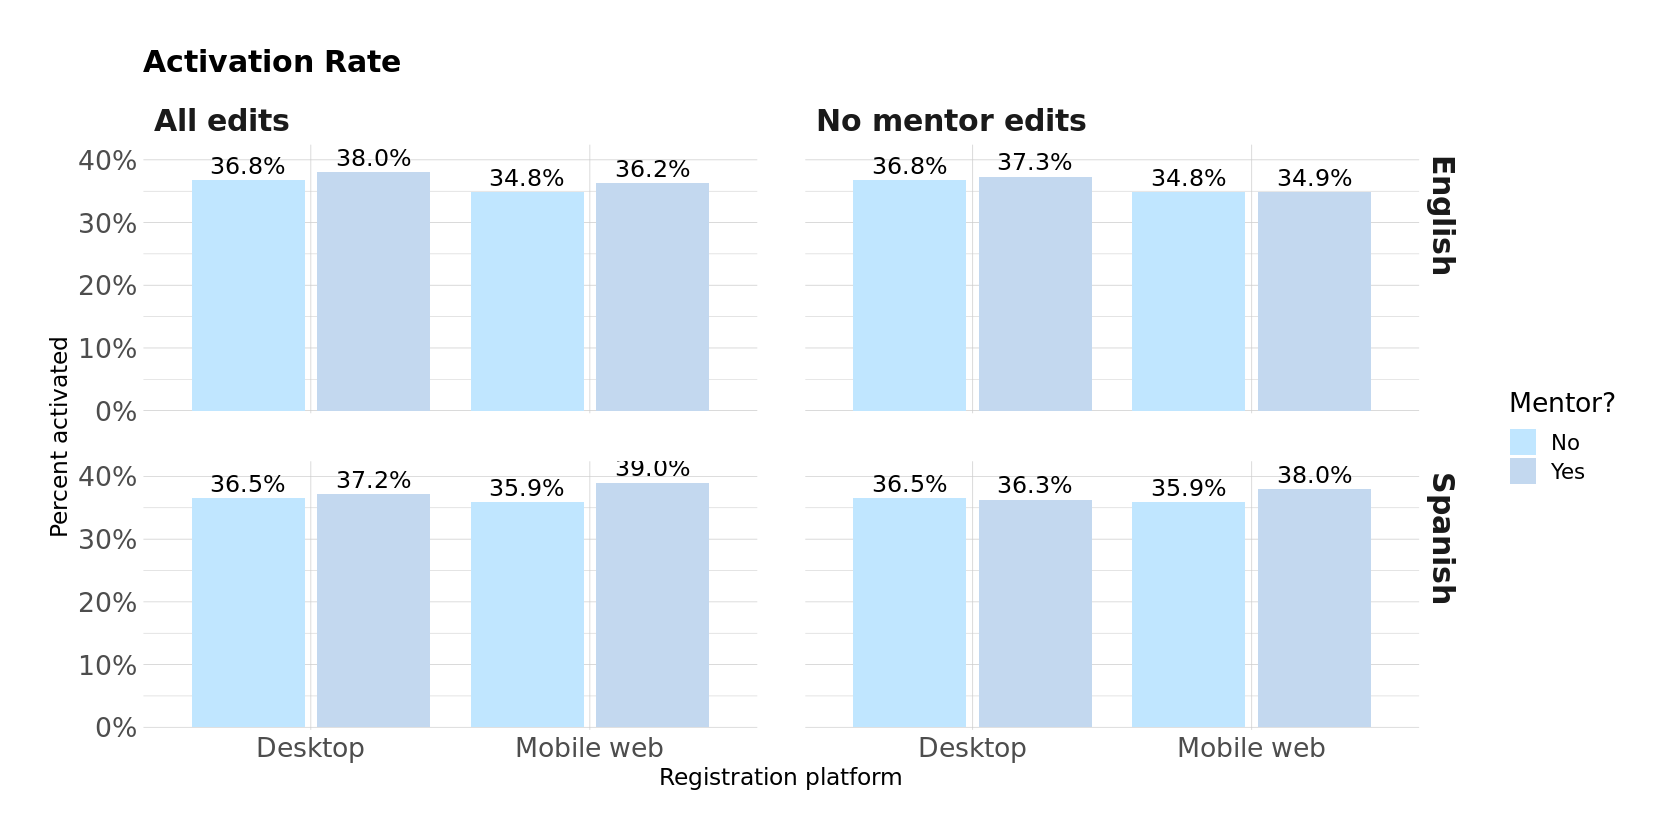

In [22]:
bind_rows(activation_props_agg, activation_nomentor_props_agg) |>
    mutate(mentor_set = ifelse(has_mentor, 'Yes', 'No')) |>
    ggplot(aes(x = platform_name, y = prob, group = mentor_set)) +
        labs(title = 'Activation Rate',
             x = 'Registration platform', y = 'Percent activated',
             fill = 'Mentor?') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        guides() +
        scale_fill_manual(values = c('No' = '#c0e6ff', 'Yes' = '#c3d8ef')) +
        hrbrthemes::scale_y_percent(limits = c(0, 0.42)) +
        geom_col(aes(fill = mentor_set), position = 'dodge2') +
        geom_text(aes(label = wmfdata::percent2(prob), y = prob + 0.01), size = 5,
                  position = position_dodge(0.9), vjust = 0) +
        facet_grid(wiki_name ~ edits_included)
ggsave(
    'mentorship-activation-with-and-without.png',
    path = 'graphs',
    width = 16, height = 9, units = "in", dpi = "print", bg = 'white')

# Questions for users who responded to the survey

We start by checking question rates based on responses to the question "Have you edited Wikipedia before?" because we in NEWTEA Revisited found that it can be transformed into a "yes/no" answer.

In [38]:
# Give me wider plots, please
options(repr.plot.width = 16, repr.plot.height = 12)
editing_with_surveys |>
    filter(response == 'save') |>
    mutate(edited_response = factor(
               edited,
               levels = c('yes-many', 'yes-few', 'dunno', 'no-other', 'dont-remember', 'placeholder'),
               labels = c('Yes, many times', 'Yes, once or twice', "No, I didn't know I could edit",
                          "No, for other reasons", "I don't remember", "Unanswered"))) |>
    group_by(wiki_name, platform_name, edited_response, has_mentor, is_activated) |>
    tally() |>
    mutate(per_group = sum(n)) |>
    ungroup() |>
    mutate(perc = 100 * n / per_group, prob = n / per_group) |>
    filter(is_activated == TRUE & is.na(edited_response) == FALSE) |>
    ggplot(aes(x = edited_response, y = prob, fill = has_mentor)) +
        labs(title = 'Activation and editing response',
             x = 'Have you edited before?', y = 'Percent activated') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        guides(fill = 'none') +
        scale_fill_brewer() +
        scale_x_discrete(guide = guide_axis(angle = 90)) +
        hrbrthemes::scale_y_percent(limits = c(0, 0.65)) +
        geom_col(position = 'dodge2') +
#        geom_text(aes(label = wmfdata::percent2(prob)), nudge_y = 0.005, size = 5) +
        facet_grid(platform_name ~ wiki_name)
#ggsave(
#    'mentorship-asking-by-did-you-edit-before.png',
#    path = 'graphs',
#    width = 16, height = 12, units = "in", dpi = "print")

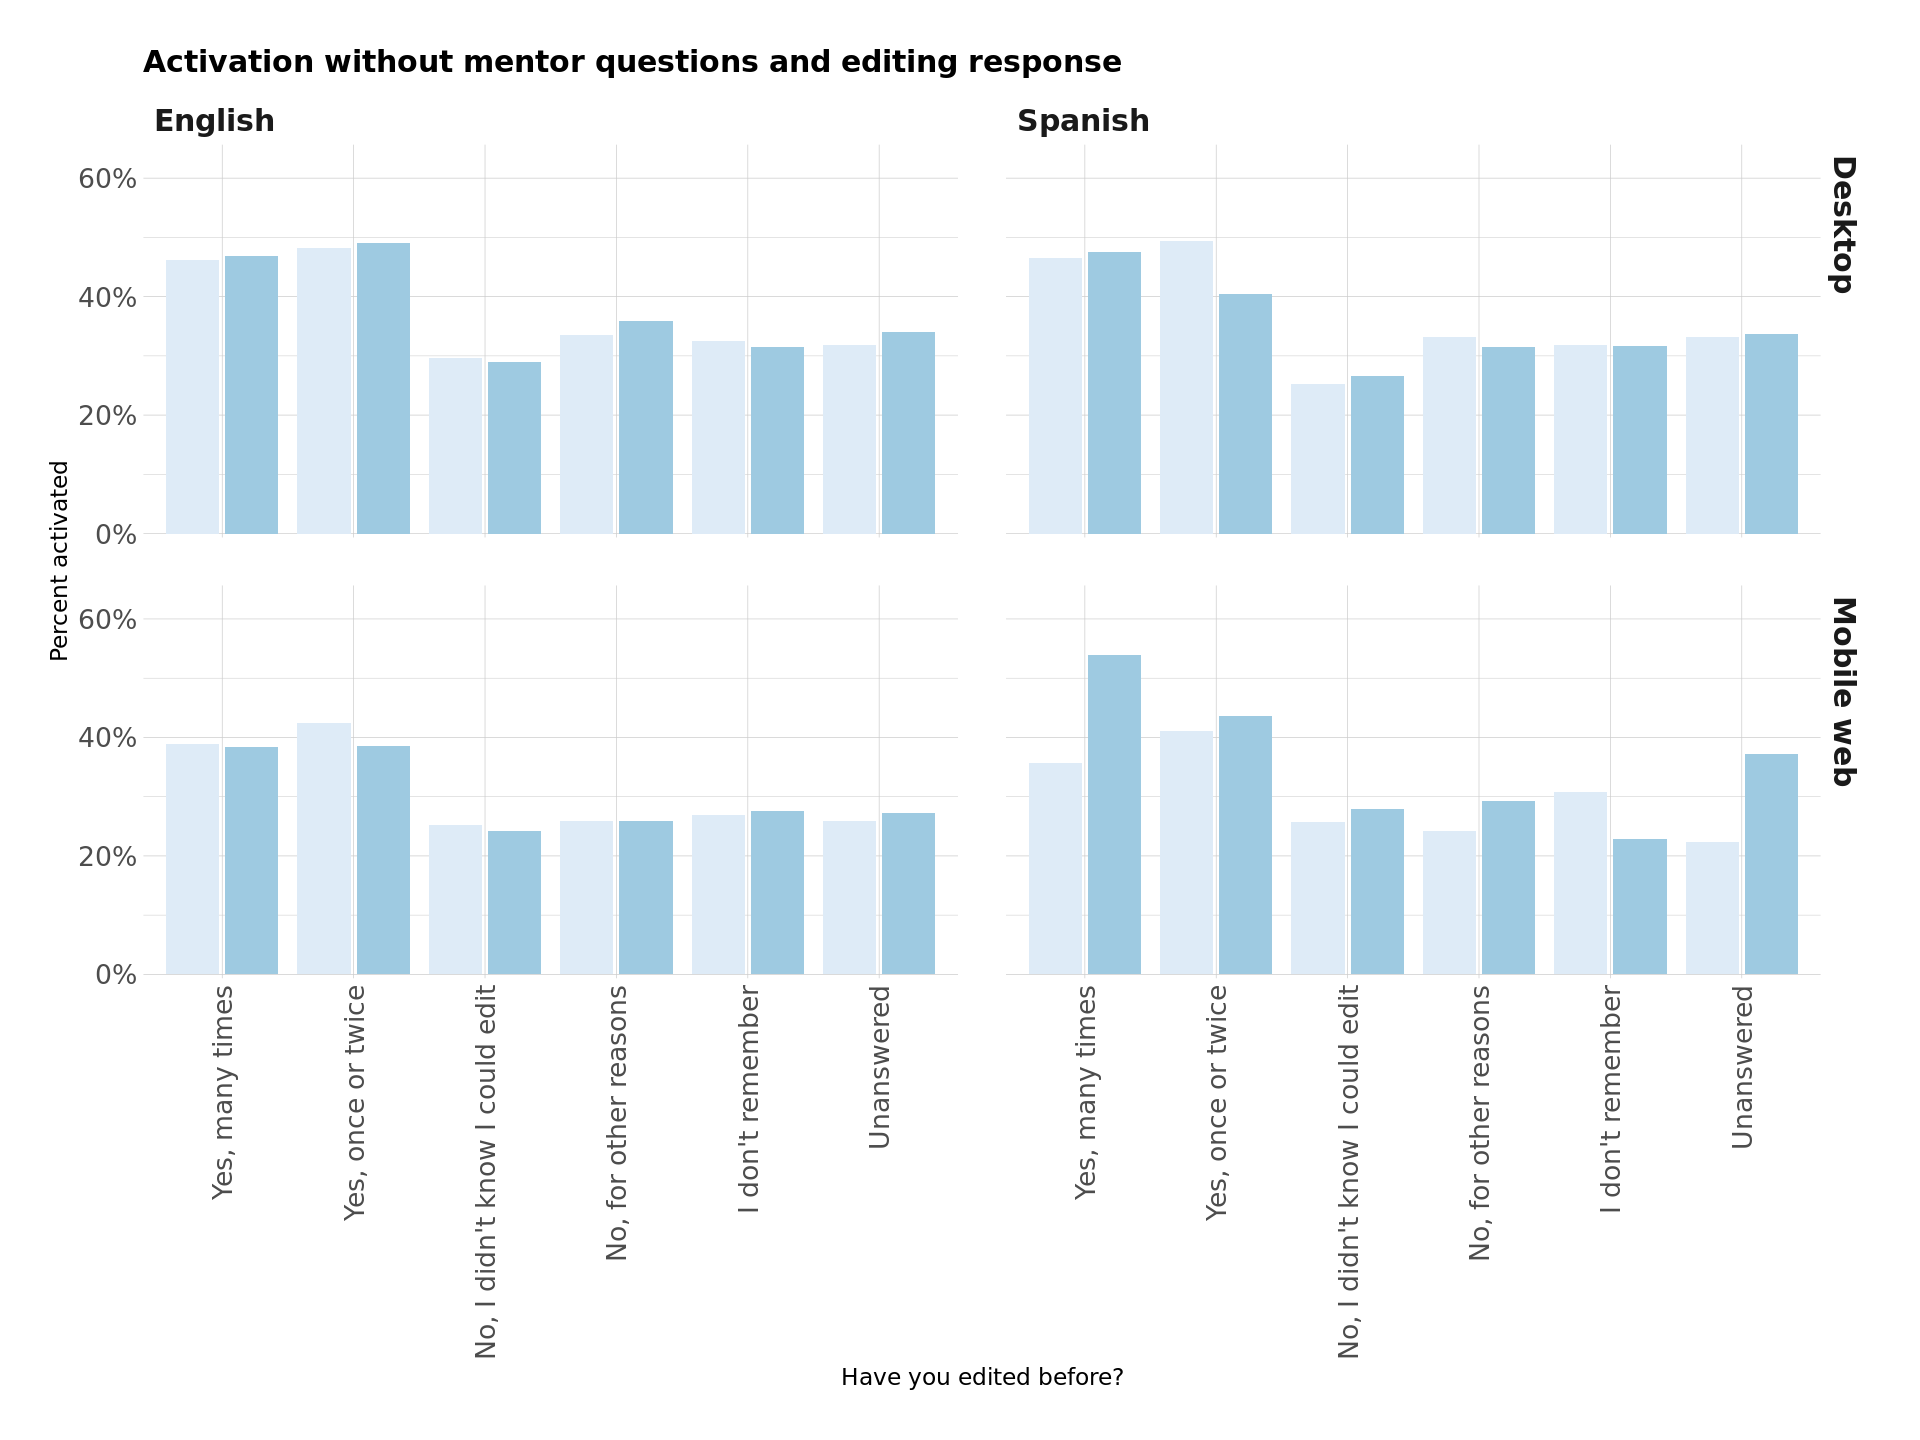

In [40]:
# Give me wider plots, please
options(repr.plot.width = 16, repr.plot.height = 12)
editing_with_surveys |>
    filter(response == 'save') |>
    mutate(edited_response = factor(
               edited,
               levels = c('yes-many', 'yes-few', 'dunno', 'no-other', 'dont-remember', 'placeholder'),
               labels = c('Yes, many times', 'Yes, once or twice', "No, I didn't know I could edit",
                          "No, for other reasons", "I don't remember", "Unanswered"))) |>
    group_by(wiki_name, platform_name, edited_response, has_mentor, is_activated_no_mentor) |>
    tally() |>
    mutate(per_group = sum(n)) |>
    ungroup() |>
    mutate(perc = 100 * n / per_group, prob = n / per_group) |>
    filter(is_activated_no_mentor == TRUE & is.na(edited_response) == FALSE) |>
    ggplot(aes(x = edited_response, y = prob, fill = has_mentor)) +
        labs(title = 'Activation without mentor questions and editing response',
             x = 'Have you edited before?', y = 'Percent activated') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        guides(fill = 'none') +
        scale_fill_brewer() +
        scale_x_discrete(guide = guide_axis(angle = 90)) +
        hrbrthemes::scale_y_percent(limits = c(0, 0.65)) +
        geom_col(position = 'dodge2') +
#        geom_text(aes(label = wmfdata::percent2(prob)), nudge_y = 0.005, size = 5) +
        facet_grid(platform_name ~ wiki_name)
#ggsave(
#    'mentorship-asking-by-did-you-edit-before.png',
#    path = 'graphs',
#    width = 16, height = 12, units = "in", dpi = "print")

In table format, please:

In [ ]:
users_with_surveys |>
    filter(mentor_enabled == 1 & response == 'save') |>
    mutate(asked_mentor = ifelse(n_mentor_edits > 0, TRUE, FALSE),
           wiki_name = ifelse(wiki_db == 'eswiki', 'Spanish', 'English'),
           platform_name = ifelse(platform == 'desktop', 'Desktop', 'Mobile web'),
           edited_response = factor(
               edited,
               levels = c('yes-many', 'yes-few', 'dunno', 'no-other', 'dont-remember', 'placeholder'),
               labels = c('Yes, many times', 'Yes, once or twice', "No, I didn't know I could edit",
                          "No, for other reasons", "I don't remember", "Unanswered"))) |>
    group_by(wiki_name, platform_name, edited_response, asked_mentor) |>
    tally() |>
    mutate(per_group = sum(n)) |>
    ungroup() |>
    mutate(perc = 100 * n / per_group, prob = n / per_group) |>
    filter(asked_mentor == TRUE & is.na(edited_response) == FALSE)

It's clear that there aren't specific patterns here like we saw in NEWTEA, meaning we can't really collapse this as we'd hoped for. We have very small counts in some of these buckets, so let's look at patterns in the other question instead.

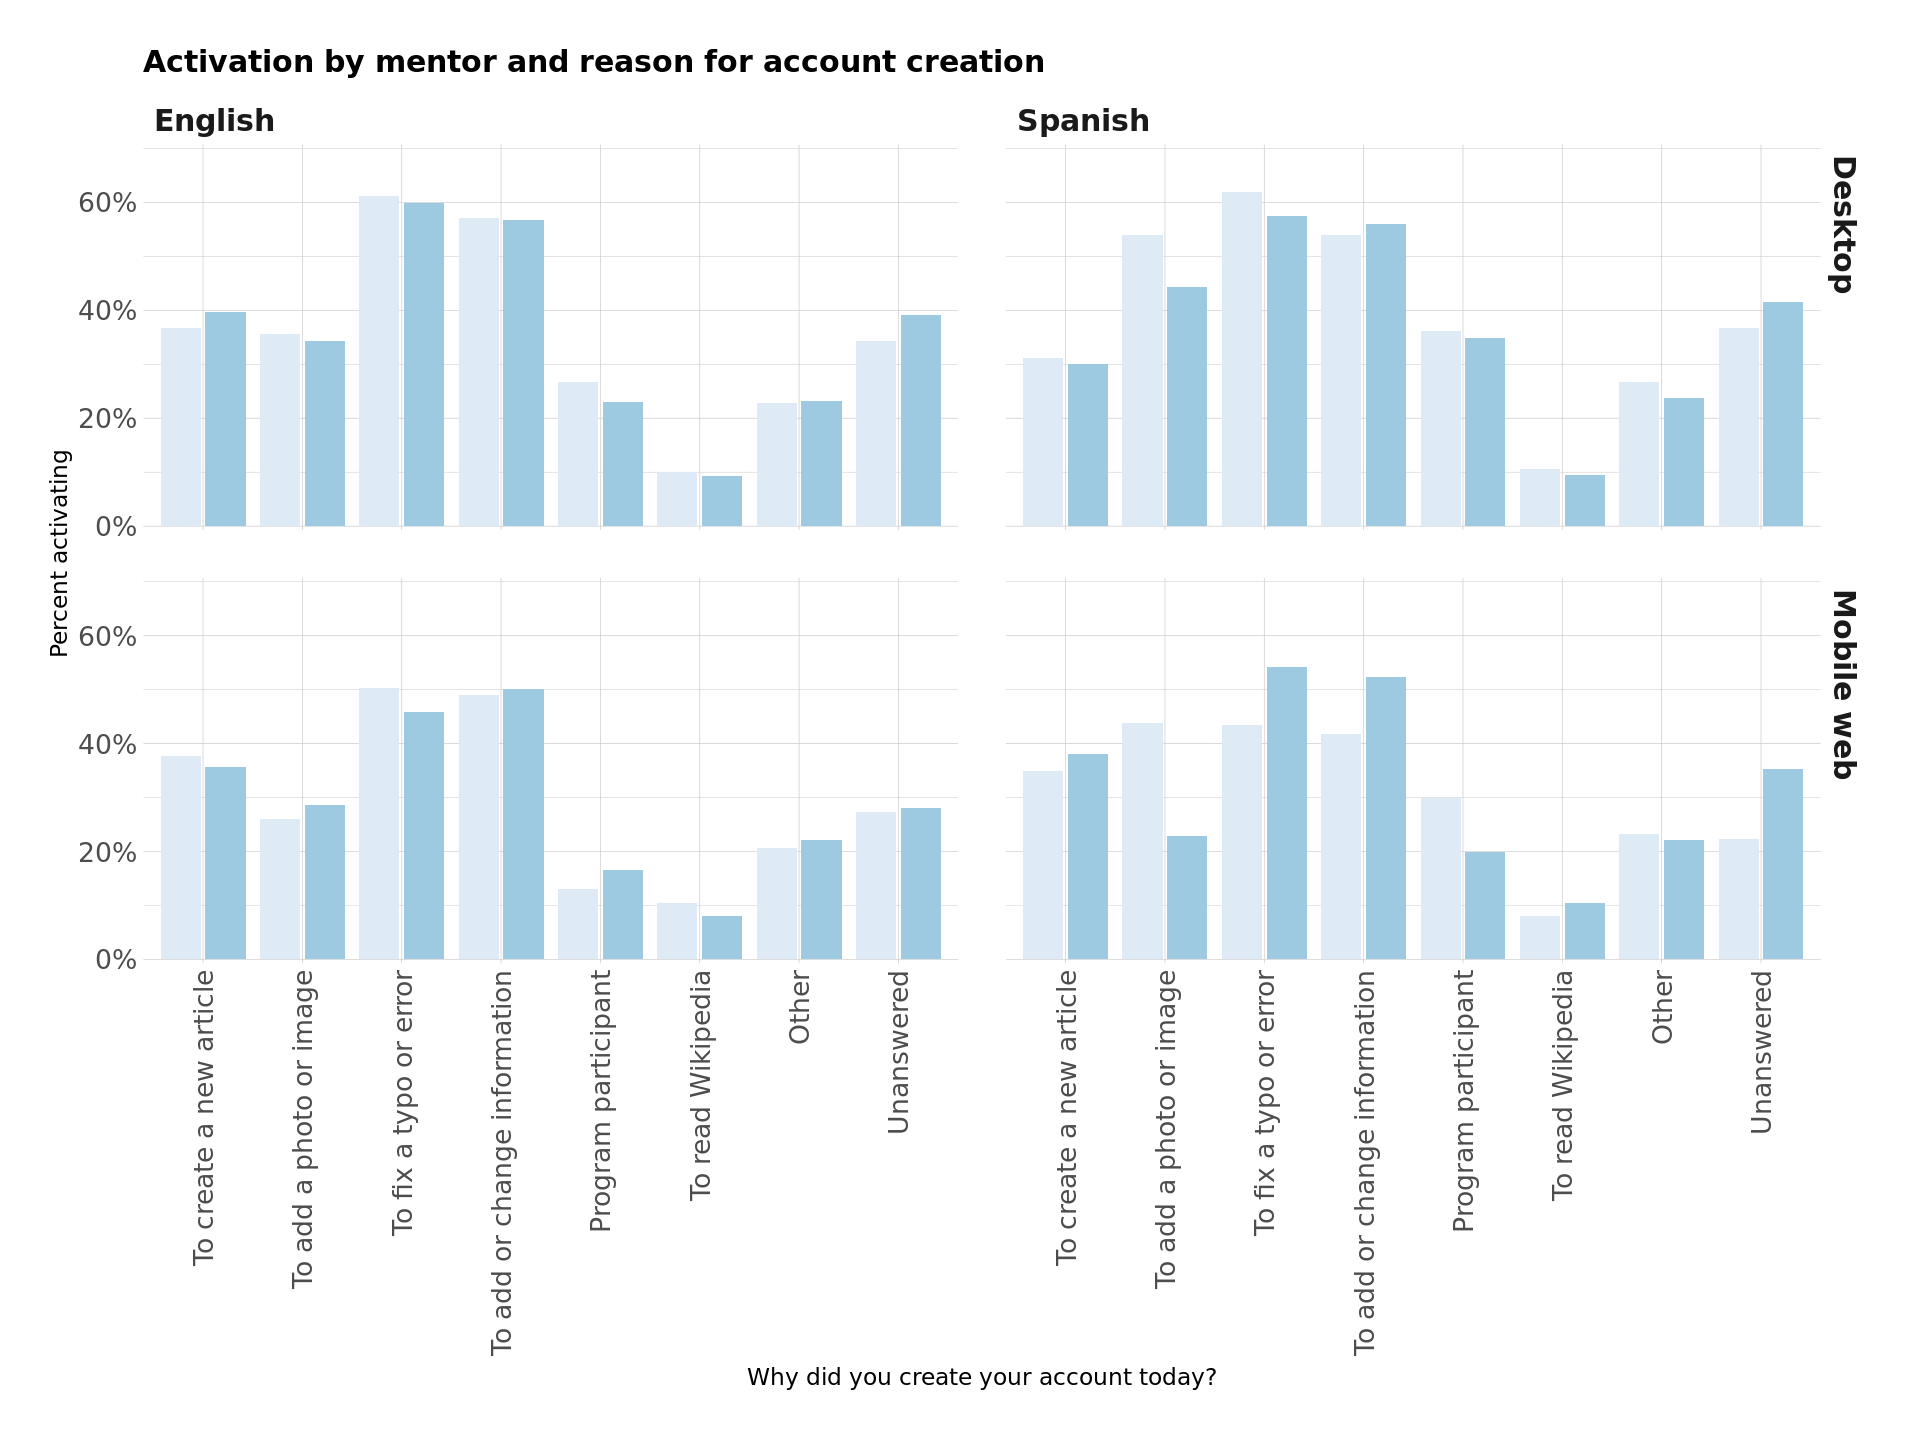

In [51]:
# Give me wider plots, please
options(repr.plot.width = 16, repr.plot.height = 12)
editing_with_surveys |>
    filter(response == 'save') |>
    mutate(wiki_name = ifelse(wiki_db == 'eswiki', 'Spanish', 'English'),
           platform_name = ifelse(platform == 'desktop', 'Desktop', 'Mobile web'),
           reason_response = factor(
               reason,
               levels = c('new-page', 'add-image', 'edit-typo', 'edit-info-add-change', 'program-participant',
                          'read', 'other', 'placeholder'),
               labels = c("To create a new article", "To add a photo or image", "To fix a typo or error",
                          "To add or change information", "Program participant", "To read Wikipedia", "Other",
                          "Unanswered"))) |>
    group_by(wiki_name, platform_name, reason_response, has_mentor, is_activated_no_mentor) |>
    tally() |>
    mutate(per_group = sum(n)) |>
    ungroup() |>
    mutate(perc = 100 * n / per_group, prob = n / per_group) |>
    filter(is_activated_no_mentor == TRUE & is.na(reason_response) == FALSE) |>
    ggplot(aes(x = reason_response, y = prob, fill = has_mentor)) +
        labs(title = 'Activation by mentor and reason for account creation',
             x = 'Why did you create your account today?', y = 'Percent activating') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        guides(fill = 'none') +
        scale_fill_brewer() +
        scale_x_discrete(guide = guide_axis(angle = 90)) +
        hrbrthemes::scale_y_percent(limits = c(0, 0.7)) +
                geom_col(position = 'dodge2') +
#        geom_text(aes(label = wmfdata::percent2(prob)), nudge_y = 0.005, size = 5) +
        facet_grid(platform_name ~ wiki_name)
#ggsave(
#    'mentorship-asking-by-account-reason.png',
#    path = 'graphs',
#    width = 16, height = 12, units = "in", dpi = "print")

In table format:

In [ ]:
users_with_surveys |>
    filter(mentor_enabled == 1 & response == 'save') |>
    mutate(asked_mentor = ifelse(n_mentor_edits > 0, TRUE, FALSE),
           wiki_name = ifelse(wiki_db == 'eswiki', 'Spanish', 'English'),
           platform_name = ifelse(platform == 'desktop', 'Desktop', 'Mobile web'),
           reason_response = factor(
               reason,
               levels = c('new-page', 'add-image', 'edit-typo', 'edit-info-add-change', 'program-participant',
                          'read', 'other', 'placeholder'),
               labels = c("To create a new article", "To add a photo or image", "To fix a typo or error",
                          "To add or change information", "Program participant", "To read Wikipedia", "Other",
                          "Unanswered"))) |>
    group_by(wiki_name, platform_name, reason_response, asked_mentor) |>
    tally() |>
    mutate(per_group = sum(n)) |>
    ungroup() |>
    mutate(perc = 100 * n / per_group, prob = n / per_group) |>
    filter(asked_mentor == TRUE & is.na(reason_response) == FALSE)

# Regression models

We'll fit these separately for English and Spanish, and examine overall activation with and without mentor edits, as well as constructive article activation.

## Overall

### English

In [53]:
blas_set_num_threads(16)
enwiki.overall.activation.model.1 <- editing_with_surveys |>
    filter(wiki_db == 'enwiki') |>
    glm(
        formula = is_activated ~ platform + has_mentor,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [54]:
summary(enwiki.overall.activation.model.1)


Call:
glm(formula = is_activated ~ platform + has_mentor, family = binomial(link = "logit"), 
    data = filter(editing_with_surveys, wiki_db == "enwiki"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.979  -0.958  -0.925   1.415   1.453  

Coefficients:
                Estimate Std. Error z value             Pr(>|z|)    
(Intercept)      -0.6271     0.0104  -60.27 < 0.0000000000000002 ***
platformdesktop   0.0849     0.0128    6.65       0.000000000029 ***
has_mentorTRUE    0.0556     0.0194    2.86               0.0042 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 149894  on 114511  degrees of freedom
Residual deviance: 149841  on 114509  degrees of freedom
AIC: 149847

Number of Fisher Scoring iterations: 4


In [55]:
blas_set_num_threads(16)
enwiki.overall.activation.model.2 <- editing_with_surveys |>
    filter(wiki_db == 'enwiki') |>
    glm(
        formula = is_activated ~ platform * has_mentor,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [56]:
summary(enwiki.overall.activation.model.2)


Call:
glm(formula = is_activated ~ platform * has_mentor, family = binomial(link = "logit"), 
    data = filter(editing_with_surveys, wiki_db == "enwiki"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.978  -0.958  -0.925   1.414   1.453  

Coefficients:
                               Estimate Std. Error z value             Pr(>|z|)
(Intercept)                     -0.6279     0.0108  -58.15 < 0.0000000000000002
platformdesktop                  0.0862     0.0136    6.36         0.0000000002
has_mentorTRUE                   0.0630     0.0321    1.96                 0.05
platformdesktop:has_mentorTRUE  -0.0116     0.0403   -0.29                 0.77
                                  
(Intercept)                    ***
platformdesktop                ***
has_mentorTRUE                 *  
platformdesktop:has_mentorTRUE    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1498

*Conclusion:* Having a mentor increases the likelihood of making an edit within the first 24 hours on English Wikipedia.

### Spanish

In [57]:
blas_set_num_threads(16)
eswiki.overall.activation.model.1 <- editing_with_surveys |>
    filter(wiki_db == 'eswiki') |>
    glm(
        formula = is_activated ~ platform + has_mentor,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [58]:
summary(eswiki.overall.activation.model.1)


Call:
glm(formula = is_activated ~ platform + has_mentor, family = binomial(link = "logit"), 
    data = filter(editing_with_surveys, wiki_db == "eswiki"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.984  -0.974  -0.944   1.396   1.430  

Coefficients:
                Estimate Std. Error z value            Pr(>|z|)    
(Intercept)      -0.5516     0.0268  -20.56 <0.0000000000000002 ***
platformdesktop  -0.0249     0.0300   -0.83                0.41    
has_mentorTRUE    0.0767     0.0298    2.57                0.01 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 25468  on 19304  degrees of freedom
Residual deviance: 25461  on 19302  degrees of freedom
AIC: 25467

Number of Fisher Scoring iterations: 4


In [59]:
blas_set_num_threads(16)
eswiki.overall.activation.model.2 <- editing_with_surveys |>
    filter(wiki_db == 'eswiki') |>
    glm(
        formula = is_activated ~ platform * has_mentor,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [60]:
summary(eswiki.overall.activation.model.2)


Call:
glm(formula = is_activated ~ platform * has_mentor, family = binomial(link = "logit"), 
    data = filter(editing_with_surveys, wiki_db == "eswiki"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.995  -0.965  -0.943   1.406   1.432  

Coefficients:
                               Estimate Std. Error z value            Pr(>|z|)
(Intercept)                     -0.5806     0.0317  -18.33 <0.0000000000000002
platformdesktop                  0.0278     0.0426    0.65              0.5141
has_mentorTRUE                   0.1346     0.0447    3.01              0.0026
platformdesktop:has_mentorTRUE  -0.1045     0.0600   -1.74              0.0815
                                  
(Intercept)                    ***
platformdesktop                   
has_mentorTRUE                 ** 
platformdesktop:has_mentorTRUE .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 25468  on

We see a marginally significant interaction. Let's split the dataset into desktop and mobile web and compare.

In [63]:
blas_set_num_threads(16)
eswiki.overall.activation.desktop.model.1 <- editing_with_surveys |>
    filter(wiki_db == 'eswiki' & platform == 'desktop') |>
    glm(
        formula = is_activated ~ has_mentor,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [67]:
summary(eswiki.overall.activation.desktop.model.1)


Call:
glm(formula = is_activated ~ has_mentor, family = binomial(link = "logit"), 
    data = filter(editing_with_surveys, wiki_db == "eswiki" & 
        platform == "desktop"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.965  -0.965  -0.953   1.406   1.419  

Coefficients:
               Estimate Std. Error z value            Pr(>|z|)    
(Intercept)     -0.5528     0.0285  -19.40 <0.0000000000000002 ***
has_mentorTRUE   0.0302     0.0400    0.75                0.45    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 14135  on 10735  degrees of freedom
Residual deviance: 14134  on 10734  degrees of freedom
AIC: 14138

Number of Fisher Scoring iterations: 4


In [68]:
blas_set_num_threads(16)
eswiki.overall.activation.mobile.model.1 <- editing_with_surveys |>
    filter(wiki_db == 'eswiki' & platform == 'mobile') |>
    glm(
        formula = is_activated ~ has_mentor,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [69]:
summary(eswiki.overall.activation.mobile.model.1)


Call:
glm(formula = is_activated ~ has_mentor, family = binomial(link = "logit"), 
    data = filter(editing_with_surveys, wiki_db == "eswiki" & 
        platform == "mobile"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.995  -0.995  -0.943   1.372   1.432  

Coefficients:
               Estimate Std. Error z value            Pr(>|z|)    
(Intercept)     -0.5806     0.0317  -18.33 <0.0000000000000002 ***
has_mentorTRUE   0.1346     0.0447    3.01              0.0026 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 11332  on 8568  degrees of freedom
Residual deviance: 11323  on 8567  degrees of freedom
AIC: 11327

Number of Fisher Scoring iterations: 4


*Conclusion:* We find a significant *increase* in activation on mobile in Spanish, and no difference on desktop.

## Overall without mentor edits

### English

In [70]:
blas_set_num_threads(16)
enwiki.overall.no_mentor.activation.model.1 <- editing_with_surveys |>
    filter(wiki_db == 'enwiki') |>
    glm(
        formula = is_activated_no_mentor ~ platform + has_mentor,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [71]:
summary(enwiki.overall.no_mentor.activation.model.1)


Call:
glm(formula = is_activated_no_mentor ~ platform + has_mentor, 
    family = binomial(link = "logit"), data = filter(editing_with_surveys, 
        wiki_db == "enwiki"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.964  -0.958  -0.924   1.414   1.454  

Coefficients:
                Estimate Std. Error z value             Pr(>|z|)    
(Intercept)      -0.6292     0.0104  -60.44 < 0.0000000000000002 ***
platformdesktop   0.0883     0.0128    6.91       0.000000000005 ***
has_mentorTRUE    0.0162     0.0195    0.83                 0.41    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 149760  on 114511  degrees of freedom
Residual deviance: 149712  on 114509  degrees of freedom
AIC: 149718

Number of Fisher Scoring iterations: 4


In [72]:
blas_set_num_threads(16)
enwiki.overall.no_mentor.activation.model.2 <- editing_with_surveys |>
    filter(wiki_db == 'enwiki') |>
    glm(
        formula = is_activated_no_mentor ~ platform * has_mentor,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [73]:
summary(enwiki.overall.no_mentor.activation.model.2)


Call:
glm(formula = is_activated_no_mentor ~ platform * has_mentor, 
    family = binomial(link = "logit"), data = filter(editing_with_surveys, 
        wiki_db == "enwiki"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.966  -0.958  -0.925   1.414   1.453  

Coefficients:
                               Estimate Std. Error z value             Pr(>|z|)
(Intercept)                    -0.62795    0.01080  -58.15 < 0.0000000000000002
platformdesktop                 0.08625    0.01356    6.36         0.0000000002
has_mentorTRUE                  0.00481    0.03238    0.15                 0.88
platformdesktop:has_mentorTRUE  0.01797    0.04058    0.44                 0.66
                                  
(Intercept)                    ***
platformdesktop                ***
has_mentorTRUE                    
platformdesktop:has_mentorTRUE    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    

*Conclusion:* We find no significant change in the likelihood of activation in English.

### Spanish

In [74]:
blas_set_num_threads(16)
eswiki.overall.no_mentor.activation.model.1 <- editing_with_surveys |>
    filter(wiki_db == 'eswiki') |>
    glm(
        formula = is_activated_no_mentor ~ platform + has_mentor,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [75]:
summary(eswiki.overall.no_mentor.activation.model.1)


Call:
glm(formula = is_activated_no_mentor ~ platform + has_mentor, 
    family = binomial(link = "logit"), data = filter(editing_with_surveys, 
        wiki_db == "eswiki"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.967  -0.958  -0.945   1.414   1.429  

Coefficients:
                Estimate Std. Error z value            Pr(>|z|)    
(Intercept)      -0.5529     0.0269  -20.59 <0.0000000000000002 ***
platformdesktop  -0.0225     0.0301   -0.75                0.45    
has_mentorTRUE    0.0352     0.0299    1.18                0.24    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 25367  on 19304  degrees of freedom
Residual deviance: 25365  on 19302  degrees of freedom
AIC: 25371

Number of Fisher Scoring iterations: 4


In [76]:
blas_set_num_threads(16)
eswiki.overall.no_mentor.activation.model.2 <- editing_with_surveys |>
    filter(wiki_db == 'eswiki') |>
    glm(
        formula = is_activated_no_mentor ~ platform * has_mentor,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [77]:
summary(eswiki.overall.no_mentor.activation.model.2)


Call:
glm(formula = is_activated_no_mentor ~ platform * has_mentor, 
    family = binomial(link = "logit"), data = filter(editing_with_surveys, 
        wiki_db == "eswiki"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.978  -0.953  -0.943   1.419   1.432  

Coefficients:
                               Estimate Std. Error z value            Pr(>|z|)
(Intercept)                     -0.5806     0.0317  -18.33 <0.0000000000000002
platformdesktop                  0.0278     0.0426    0.65               0.514
has_mentorTRUE                   0.0908     0.0448    2.03               0.043
platformdesktop:has_mentorTRUE  -0.1002     0.0601   -1.67               0.095
                                  
(Intercept)                    ***
platformdesktop                   
has_mentorTRUE                 *  
platformdesktop:has_mentorTRUE .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null 

We find the same marginally significant interaction as before, and again split the dataset up.

In [78]:
blas_set_num_threads(16)
eswiki.overall.no_mentor.activation.desktop.model.1 <- editing_with_surveys |>
    filter(wiki_db == 'eswiki' & platform == 'desktop') |>
    glm(
        formula = is_activated_no_mentor ~ has_mentor,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [79]:
summary(eswiki.overall.no_mentor.activation.desktop.model.1)


Call:
glm(formula = is_activated_no_mentor ~ has_mentor, family = binomial(link = "logit"), 
    data = filter(editing_with_surveys, wiki_db == "eswiki" & 
        platform == "desktop"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.953  -0.953  -0.950   1.419   1.424  

Coefficients:
               Estimate Std. Error z value            Pr(>|z|)    
(Intercept)    -0.55282    0.02850  -19.40 <0.0000000000000002 ***
has_mentorTRUE -0.00948    0.04012   -0.24                0.81    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 14080  on 10735  degrees of freedom
Residual deviance: 14080  on 10734  degrees of freedom
AIC: 14084

Number of Fisher Scoring iterations: 4


In [80]:
blas_set_num_threads(16)
eswiki.overall.no_mentor.activation.mobile.model.1 <- editing_with_surveys |>
    filter(wiki_db == 'eswiki' & platform == 'mobile') |>
    glm(
        formula = is_activated_no_mentor ~ has_mentor,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [81]:
summary(eswiki.overall.no_mentor.activation.mobile.model.1)


Call:
glm(formula = is_activated_no_mentor ~ has_mentor, family = binomial(link = "logit"), 
    data = filter(editing_with_surveys, wiki_db == "eswiki" & 
        platform == "mobile"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.978  -0.978  -0.943   1.391   1.432  

Coefficients:
               Estimate Std. Error z value            Pr(>|z|)    
(Intercept)     -0.5806     0.0317  -18.33 <0.0000000000000002 ***
has_mentorTRUE   0.0908     0.0448    2.03               0.043 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 11286  on 8568  degrees of freedom
Residual deviance: 11282  on 8567  degrees of freedom
AIC: 11286

Number of Fisher Scoring iterations: 4


*Conclusion:* For Spanish, we find no difference on desktop but a *significant increase* in activation on mobile.

## Constructive article activation

### English

In [84]:
blas_set_num_threads(16)
enwiki.constr_article_activation.model.1 <- editing_with_surveys |>
    filter(wiki_db == 'enwiki') |>
    glm(
        formula = is_const_activated_article ~ platform + has_mentor,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [85]:
summary(enwiki.constr_article_activation.model.1)


Call:
glm(formula = is_const_activated_article ~ platform + has_mentor, 
    family = binomial(link = "logit"), data = filter(editing_with_surveys, 
        wiki_db == "enwiki"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.641  -0.641  -0.639  -0.609   1.888  

Coefficients:
                Estimate Std. Error z value             Pr(>|z|)    
(Intercept)     -1.59107    0.01322 -120.36 < 0.0000000000000002 ***
platformdesktop  0.11285    0.01610    7.01      0.0000000000024 ***
has_mentorTRUE  -0.00723    0.02451   -0.30                 0.77    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 107775  on 114511  degrees of freedom
Residual deviance: 107725  on 114509  degrees of freedom
AIC: 107731

Number of Fisher Scoring iterations: 4


In [86]:
blas_set_num_threads(16)
enwiki.constr_article_activation.model.2 <- editing_with_surveys |>
    filter(wiki_db == 'enwiki') |>
    glm(
        formula = is_const_activated_article ~ platform * has_mentor,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [87]:
summary(enwiki.constr_article_activation.model.2)


Call:
glm(formula = is_const_activated_article ~ platform * has_mentor, 
    family = binomial(link = "logit"), data = filter(editing_with_surveys, 
        wiki_db == "enwiki"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.642  -0.641  -0.641  -0.610   1.896  

Coefficients:
                               Estimate Std. Error z value             Pr(>|z|)
(Intercept)                     -1.5889     0.0137 -115.90 < 0.0000000000000002
platformdesktop                  0.1094     0.0171    6.41        0.00000000014
has_mentorTRUE                  -0.0272     0.0415   -0.66                 0.51
platformdesktop:has_mentorTRUE   0.0308     0.0514    0.60                 0.55
                                  
(Intercept)                    ***
platformdesktop                ***
has_mentorTRUE                    
platformdesktop:has_mentorTRUE    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)



*Conclusion:* We find no difference in constructive article activation for newcomers with mentors on English Wikipedia.

### Spanish

In [88]:
blas_set_num_threads(16)
eswiki.constr_article_activation.model.1 <- editing_with_surveys |>
    filter(wiki_db == 'eswiki') |>
    glm(
        formula = is_const_activated_article ~ platform + has_mentor,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [89]:
summary(eswiki.constr_article_activation.model.1)


Call:
glm(formula = is_const_activated_article ~ platform + has_mentor, 
    family = binomial(link = "logit"), data = filter(editing_with_surveys, 
        wiki_db == "eswiki"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.735  -0.719  -0.697  -0.682   1.773  

Coefficients:
                Estimate Std. Error z value             Pr(>|z|)    
(Intercept)      -1.3392     0.0316  -42.35 < 0.0000000000000002 ***
platformdesktop   0.1183     0.0350    3.39              0.00071 ***
has_mentorTRUE    0.0490     0.0346    1.42              0.15644    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 20494  on 19304  degrees of freedom
Residual deviance: 20481  on 19302  degrees of freedom
AIC: 20487

Number of Fisher Scoring iterations: 4


In [90]:
blas_set_num_threads(16)
eswiki.constr_article_activation.model.2 <- editing_with_surveys |>
    filter(wiki_db == 'eswiki') |>
    glm(
        formula = is_const_activated_article ~ platform * has_mentor,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [91]:
summary(eswiki.constr_article_activation.model.2)


Call:
glm(formula = is_const_activated_article ~ platform * has_mentor, 
    family = binomial(link = "logit"), data = filter(editing_with_surveys, 
        wiki_db == "eswiki"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.727  -0.727  -0.708  -0.672   1.788  

Coefficients:
                               Estimate Std. Error z value             Pr(>|z|)
(Intercept)                     -1.3731     0.0378  -36.30 < 0.0000000000000002
platformdesktop                  0.1777     0.0499    3.56              0.00036
has_mentorTRUE                   0.1161     0.0529    2.19              0.02829
platformdesktop:has_mentorTRUE  -0.1171     0.0699   -1.67              0.09398
                                  
(Intercept)                    ***
platformdesktop                ***
has_mentorTRUE                 *  
platformdesktop:has_mentorTRUE .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)



We see the same pattern here as we saw for overall activation, and split the dataset up again.

In [92]:
blas_set_num_threads(16)
eswiki.constr_article_activation.desktop.model.1 <- editing_with_surveys |>
    filter(wiki_db == 'eswiki' & platform == 'desktop') |>
    glm(
        formula = is_const_activated_article ~ has_mentor,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [93]:
summary(eswiki.constr_article_activation.desktop.model.1)


Call:
glm(formula = is_const_activated_article ~ has_mentor, family = binomial(link = "logit"), 
    data = filter(editing_with_surveys, wiki_db == "eswiki" & 
        platform == "desktop"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.727  -0.727  -0.727  -0.727   1.709  

Coefficients:
               Estimate Std. Error z value            Pr(>|z|)    
(Intercept)    -1.19535    0.03249  -36.79 <0.0000000000000002 ***
has_mentorTRUE -0.00105    0.04572   -0.02                0.98    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 11636  on 10735  degrees of freedom
Residual deviance: 11636  on 10734  degrees of freedom
AIC: 11640

Number of Fisher Scoring iterations: 4


In [94]:
blas_set_num_threads(16)
eswiki.constr_article_activation.mobile.model.1 <- editing_with_surveys |>
    filter(wiki_db == 'eswiki' & platform == 'mobile') |>
    glm(
        formula = is_const_activated_article ~ has_mentor,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [95]:
summary(eswiki.constr_article_activation.mobile.model.1)


Call:
glm(formula = is_const_activated_article ~ has_mentor, family = binomial(link = "logit"), 
    data = filter(editing_with_surveys, wiki_db == "eswiki" & 
        platform == "mobile"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.708  -0.708  -0.672  -0.672   1.788  

Coefficients:
               Estimate Std. Error z value            Pr(>|z|)    
(Intercept)     -1.3731     0.0378  -36.30 <0.0000000000000002 ***
has_mentorTRUE   0.1161     0.0529    2.19               0.028 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 8846.5  on 8568  degrees of freedom
Residual deviance: 8841.7  on 8567  degrees of freedom
AIC: 8846

Number of Fisher Scoring iterations: 4


*Conclusion:* We find a significant increase in the likelihood of activating through constructive article edits in Spanish for users who registered on mobile web, and no difference for those who registered on desktop.